### Analysis of Startup Failures

My goal here is to analyze the reports of startup failures (and successes!) collected by failory (and possibly other websites)

In [18]:
googlemaps_api_key = "not a valid key"

#### 1. Scrape data, store in SQL database

In [79]:
import sys
!{sys.executable}  -m pip install keras
#!{sys.executable} -m pip install beautifulsoup4
#!{sys.executable} -m pip install requests

    100% |████████████████████████████████| 317kB 2.1MB/s ta 0:00:01
    100% |████████████████████████████████| 266kB 2.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /Users/cstoneki/Library/Caches/pip/wheels/d9/45/dd/65f0b38450c47cf7e5312883deb97d065e030c5cca0a365030
Successfully built pyyaml
You are using pip version 18.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
import os
import sqlite3
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
main_urls = {'failory failure':'https://www.failory.com/interview-failure',
             'failory success':'https://www.failory.com/interview-success'}

In [62]:
def insert_report(cur,  url, text, tags):
    cur.execute('SELECT text FROM Startups WHERE url = ?', (url,))
    #? -> avoid SQL injection
    row = cur.fetchone()
    if(row is None):
        cur.execute('''INSERT INTO Startups (url, text, tags)
            VALUES (?, ?, ?)''', (url, text, tags))
        return True
    else:
        return False

In [2]:
conn = sqlite3.connect('startups_03.sqlite')
cur = conn.cursor()
cur.execute('CREATE TABLE IF NOT EXISTS Startups (url TEXT, text TEXT, tags TEXT) ')

In [64]:
for tags, url in main_urls.items():
    print('\ncollecting articles from '+url+'\n')
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    a_tags = soup.findAll('a')
    sub_urls = []
    for i in range(len(a_tags)):
        try:
            if(a_tags[i]["class"][0] =='card-for-interviews-title'):
                sub_urls.append(a_tags[i]["href"])
        except:
            continue
    for sub_url in sub_urls:
        full_url = 'https://www.failory.com' + sub_url
        article  = requests.get(full_url)
        print('downloaded '+full_url)
        time.sleep(1)
        
        insert_report(cur, full_url, article.text, tags)
        conn.commit()


collecting articles from https://www.failory.com/interview-failure

downloaded https://www.failory.com/interview/140-canvas
downloaded https://www.failory.com/interview/singulution
downloaded https://www.failory.com/interview/nox
downloaded https://www.failory.com/interview/wedmap
downloaded https://www.failory.com/interview/profitabilly
downloaded https://www.failory.com/interview/tailor
downloaded https://www.failory.com/interview/hubrif
downloaded https://www.failory.com/interview/repitchbook
downloaded https://www.failory.com/interview/lieferoo
downloaded https://www.failory.com/interview/tandem-app
downloaded https://www.failory.com/interview/twitch-highlights
downloaded https://www.failory.com/interview/wantremotejob
downloaded https://www.failory.com/interview/jobridge
downloaded https://www.failory.com/interview/notezilla
downloaded https://www.failory.com/interview/haptly
downloaded https://www.failory.com/interview/chowdy
downloaded https://www.failory.com/interview/zor-tech

In [65]:
#check contents of database
#by retrieving small text fields, not full text
sqlstr = 'SELECT url, tags FROM Startups'
database_dict = {}
for row in cur.execute(sqlstr):
    database_dict[str(row[0])] = [row[1]]

In [69]:
#print text of first article
sqlstr = 'SELECT url, text, tags FROM Startups'
for k, row in enumerate(cur.execute(sqlstr)):
    if(k > 0): break
    soup = BeautifulSoup(row[1], "html.parser")
    print(soup)

<!DOCTYPE html>
<!-- Last Published: Thu Jul 18 2019 02:10:31 GMT+0000 (UTC) --><html data-wf-domain="www.failory.com" data-wf-page="5aac45db682f563eb2c4aeae" data-wf-site="5966ea9a9217ca534caf139f" lang="en"><head><meta charset="utf-8"/><title>140 Canvas: +17,000 visitors, 20 sales - The failed non-validated startup</title><meta content="After dropping out of university, Harry went back home and found a gift: a fake big tweet from Federer. Thatâs when he came with a business idea: fake tweets printed and sold for Â£30. He launched this in 2 months, but a conversion of 0.11% made him realize people weren't interested in the product." name="description"/><meta content="140 Canvas: +17,000 visitors, 20 sales - The failed non-validated startup" property="og:title"/><meta content="After dropping out of university, Harry went back home and found a gift: a fake big tweet from Federer. Thatâs when he came with a business idea: fake tweets printed and sold for Â£30. He launched this in 2 m

#### 2. Process HTML data

Now we need to figure out how to extract the text of the article from the mess of HTML. We need to strip out all of the ads and repeated quotes. One key part will be extracting the interviewer's questions, and the response that follows.

In [5]:

#failory has tags at the start of each article
#these are: location, area, failure cause #1, failure cause #2
#these are obviously extremely useful, so we want to extract them
#try to find location
def get_failory_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    article_tags = []
    div_tags = soup.findAll('div')
    for i in range(len(div_tags)):
        try:
            if(div_tags[i]["class"][0] =="secondary-tag-interview"):
                if(div_tags[i].text):
                    article_tags.append(div_tags[i].text)
        except:
            continue
    return article_tags

In [3]:
database_dict_list = []
sqlstr = 'SELECT url, text, tags FROM Startups'
for row in cur.execute(sqlstr):
    entry = {}
    entry['url'] = row[0]
    entry['text'] = row[1]
    entry['tags'] = row[2]
    database_dict_list.append(entry)



In [6]:
for entry in database_dict_list:
    if('failory' in entry['tags']):
        #the following will only work for failory articles
        #so check because we may have non-failory articles in database later
        entry['failory_tags'] = get_failory_tags(entry['text'])

In [7]:
database_dict_list[3]

{'url': 'https://www.failory.com/interview/wedmap',
 'text': '<!DOCTYPE html><!-- Last Published: Thu Jul 18 2019 02:10:31 GMT+0000 (UTC) --><html data-wf-domain="www.failory.com" data-wf-page="5aac45db682f563eb2c4aeae" data-wf-site="5966ea9a9217ca534caf139f" lang="en"><head><meta charset="utf-8"/><title>WedMap: From $100K Jobs to Failed Airbnb for Weddings</title><meta content="With the objective of digitizing the wedding planning process, Tauras co-founded WedMap. They launched the tool within some months and carried out many marketing strategies, which led to a MRR of $2k. However, different problems on team, resources, skills, and product meant WedMapâ\x80\x99s failure." name="description"/><meta content="WedMap: From $100K Jobs to Failed Airbnb for Weddings" property="og:title"/><meta content="With the objective of digitizing the wedding planning process, Tauras co-founded WedMap. They launched the tool within some months and carried out many marketing strategies, which led to a M

In [30]:
country_list = [entry['failory_tags'][0] for entry in database_dict_list if 'failory_tags' in entry]

In [31]:
print(set(country_list))

{'Indonesia', 'Bulgaria', 'Sweden', 'Belgium', 'United States', 'Slovenia', 'Italy', 'Pakistan', 'Australia', 'Thailand', 'Denmark', 'Canada', 'Singapore', 'New Zealand', 'Mexico', 'Germany', 'Spain', 'Trinidad and Tobago', 'France', 'Latvia', 'United Kingdom', 'India', 'Nigeria', 'Puerto Rico', 'Israel', 'Switzerland', 'Dubai', 'Netherlands'}


In [41]:
import pandas as pd
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="startup-analysis")

#get coordinates for each country
locations = []
scales = []
for c in list(set(country_list)):
    
    location = geolocator.geocode(c)
    scales.append(int(np.sum(np.array(country_list)==c)))
    entry = {}
    entry['latitude'] = location.latitude
    entry['longitude'] = location.longitude
    locations.append(entry)
locations = pd.DataFrame(locations)

In [46]:
scales_to_plot = [int(np.floor(1.5*np.sqrt(s) + 0.5)) for s in scales]

In [127]:
import gmaps
gmaps.configure(api_key=googlemaps_api_key)
coordinates = (30, 0)
fig = gmaps.figure(center=coordinates, zoom_level=2, layout={'width': '1000px', 'height': '600px'})


startup_layer = gmaps.symbol_layer(
    locations, fill_color='blue', stroke_color='blue', scale = scales_to_plot
)
fig.add_layer(startup_layer)
fig

Figure(layout=FigureLayout(height='600px', width='1000px'))

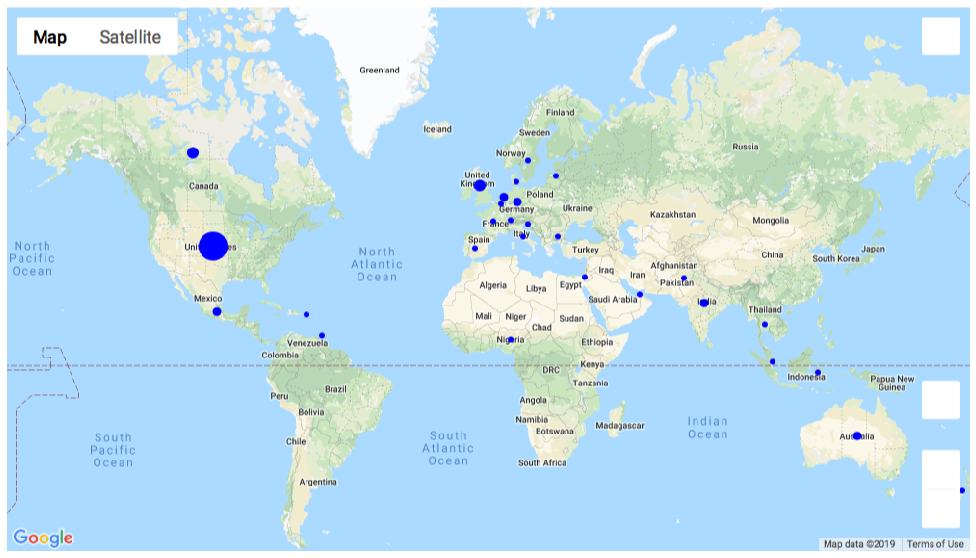

In [141]:
#display a previously saved image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(20,10))
img=mpimg.imread('map.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
#now try to extract text of interest
def get_questions_responses(text):

    soup = BeautifulSoup(text, "html.parser")
    tags = soup.findAll(['h4', 'p'])
    tags_clean = []
    for i in range(len(tags)):
        try:
            if(tags[i]["class"][0]):
                continue
        except:
            tags_clean.append(tags[i])
        
    questions = []
    responses = []
    current_text = []
    current_question = ""
    for i in range(len(tags_clean)):
        if(tags_clean[i].name=='h4'):
            if(current_question):
                questions.append(current_question)
                responses.append(" ".join(current_text))
            current_question = tags_clean[i].text
            current_text = []
        else:
            current_text.append(tags_clean[i].text)
            
    return (questions, responses)
        



In [9]:
for entry in database_dict_list:
    q,r = get_questions_responses(entry['text'])
    entry['questions'] = q
    entry['responses'] = r

In [10]:
database_dict_list[0]['questions']

['Hi Harry! What motivated you to start a business?',
 'Why 140 Canvas?',
 'How did you build it?',
 'Which were your marketing strategies to grow your business?',
 'Which were the causes of 140 Canvas failure?',
 'If you had to start over, what would you do differently?',
 'â\x80\x8dWhich were your expenses? Did you achieve some revenue? In the end, how much money did you lose?',
 'Which are your favorite entrepreneurial resources?']

In [11]:
database_dict_list[-1]['questions']

["Hi Mikkel! What's your background, and what are you currently working on?",
 "What's your backstory and how did you come up with the idea? ",
 'How did you build 10er?',
 'Which were your marketing strategies to grow your business?',
 'What were the biggest challenges you faced and obstacles you overcame?',
 'Which are your greatest disadvantages?',
 'During the process of building & growing 10er, which were the worst mistakes you committed?',
 'If you had the chance to do things differently, what would you do?',
 'Apart from mistakes, what are other sources for learning you would recommend for entrepreneurs who are just starting?']

We've spent a bit of computational time developing database_dict_list, so save it as json. Use json rather than sql a) because it's much easier to handle fields that are lists of variable length and b) because we are not growing the data entry-by-entry, but dumping a single finished database.

In [12]:
import json

with open('data.json', 'w') as fp:
    json.dump(database_dict_list, fp)

## Start here if loading from json

In [20]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
import json
with open('data.json', 'r') as fp:
    data = json.load(fp)

In [22]:
import numpy as np
#determine which tags failory has used
failure_reason_tags = []
area_tags = []

for d in data:
    
    if('failure' in d['tags'].split()):
        failure_reason_tags = failure_reason_tags + d['failory_tags'][2:3]
        
failure_reason_tags = np.array(failure_reason_tags)

In [23]:
#failure_reason_tags

unique_failure_reasons = np.unique(failure_reason_tags)
counts = np.array([np.sum(failure_reason_tags==r) for r in unique_failure_reasons])
order = np.argsort(counts)
counts = counts[order]
labels = unique_failure_reasons[order]

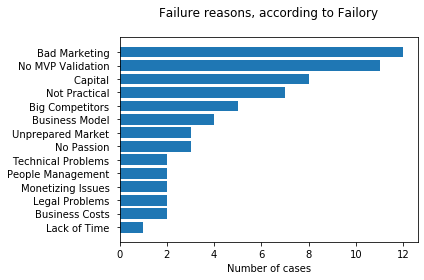

In [24]:
vals = np.arange(len(counts))
plt.barh(vals,counts)
plt.yticks(vals, [lab + " " for lab in labels])
plt.title('Failure reasons, according to Failory\n')
plt.xlabel('Number of cases')
plt.tight_layout()
plt.show()

### Word Embeddings

Now start to work with word embeddings

Use pretrained GloVe embeddings from https://nlp.stanford.edu/projects/glove/

Specifically, the 6B dataset

In [12]:
glove_pretrained_embeddings_path = '/users/cstoneki/Documents/analysis/general_resources/glove.6B/glove.6B.300d.txt'
#glove_pretrained_embeddings_path = '/mnt/glove.6B.50d.txt'

In [13]:
import numpy as np
with open(glove_pretrained_embeddings_path) as f:
    n_entries = 0
    d = 0
    
    for k, line in enumerate(f.readlines()):
        n_entries = k + 1
        #the first entry is "the", it is well formatted
        if(k==0): d = len(line.split()) - 1
    glove_data = np.zeros([d, n_entries])
    words = []
    #store each entry (word) as column
    print('Found %d words in glove dataset'%n_entries)
    f.seek(0)
    for k, line in enumerate(f.readlines()):
        lst = line.split()
        words.append(lst[0])
        vals = np.array([float(s) for s in lst[1:]])
        glove_data[:,k] = vals
        if(k % 10000==0):
            print('Words loaded : %06d '%k)
    print('Finished loading data')
        

Found 400000 words in glove dataset
Words loaded : 000000 
Words loaded : 010000 
Words loaded : 020000 
Words loaded : 030000 
Words loaded : 040000 
Words loaded : 050000 
Words loaded : 060000 
Words loaded : 070000 
Words loaded : 080000 
Words loaded : 090000 
Words loaded : 100000 
Words loaded : 110000 
Words loaded : 120000 
Words loaded : 130000 
Words loaded : 140000 
Words loaded : 150000 
Words loaded : 160000 
Words loaded : 170000 
Words loaded : 180000 
Words loaded : 190000 
Words loaded : 200000 
Words loaded : 210000 
Words loaded : 220000 
Words loaded : 230000 
Words loaded : 240000 
Words loaded : 250000 
Words loaded : 260000 
Words loaded : 270000 
Words loaded : 280000 
Words loaded : 290000 
Words loaded : 300000 
Words loaded : 310000 
Words loaded : 320000 
Words loaded : 330000 
Words loaded : 340000 
Words loaded : 350000 
Words loaded : 360000 
Words loaded : 370000 
Words loaded : 380000 
Words loaded : 390000 
Finished loading data


In [18]:
glove_df = pd.DataFrame(glove_data, columns=words)

Group data into sentences, not single words

In [20]:
#compute word embeddings from a piece of text
#keep the grouping of words into sentences

#return: sentence_embeddings = list of embedded sentences
#           if output == "index":
#           each embedded sentence is a N x 1 vector of indices into embedding matrix
#           where N = number of tokens in the sentence
#           if output == "full_embedding"
#           each embedded sentence is a M x N matrix
#           where M is embedding space dimension, N is number of tokens in the sentence
#        valid_sentences = list of raw text (string) of embedded sentences
def embed_grouped_by_sentence(glove_df, text, output="index"):
    sentences = [s for s in text.split(".") if len(s.split()) > 1]
    sentence_embeddings = []
    valid_sentences = []
    for s in sentences:
        single_word_embeddings = []
        words = s.split()
        for w in words:
            if(w in glove_df.columns):
                if(output=="full_embedding"):
                    single_word_embeddings.append(glove_df[w].values[:,np.newaxis])
                elif(output=="index"):
                    single_word_embeddings.append(glove_df.columns.get_loc(w))
        if(len(single_word_embeddings) > 1):
            if(output=="full_embedding"):
                sentence_embeddings.append(np.concatenate(single_word_embeddings, axis=1))
            elif(output=="index"):
                sentence_embeddings.append(np.array(single_word_embeddings))
            valid_sentences.append(s)
    return (sentence_embeddings, valid_sentences)

In [21]:
glove_df.head(10)

,the,",",.,of,to,and,in,a,"""",'s,...,sigarms,katuna,aqm,1.3775,corythosaurus,chanty,kronik,rolonda,zsombor,sandberger
0,0.046560,-0.255390,-0.125590,-0.076947,-0.257560,0.038466,-0.443990,-0.297120,0.694700,-0.001272,...,0.146490,-0.030013,0.46348,0.713760,0.886490,0.392700,0.136790,0.075713,0.814510,0.429191
1,0.213180,-0.257230,0.013630,-0.021211,-0.057132,-0.039792,0.128170,0.094049,0.221840,0.365140,...,-0.472660,0.246260,-0.42811,-0.566250,-0.095745,-0.022505,-0.139090,-0.040502,-0.362210,-0.296897
2,-0.007436,0.131690,0.103060,0.212710,-0.671900,0.082747,-0.252470,-0.096662,0.105260,-0.077363,...,0.171440,0.068192,0.45750,-0.184680,0.189610,0.304580,-0.360890,0.183450,0.311860,0.150110
3,-0.458540,-0.042688,-0.101230,-0.722320,-0.380820,-0.389230,-0.185820,-0.344000,0.012382,-0.265590,...,0.264310,0.089033,0.25317,0.301040,0.012919,0.187990,0.079864,0.512300,0.813810,0.245201
4,-0.035639,0.218170,0.098128,-0.139880,-0.364210,-0.214310,-0.166140,-0.184830,-0.255800,0.179870,...,-0.138950,-0.199770,0.58327,-0.564430,-0.409250,0.141180,0.321490,-0.228560,0.188520,-0.003520
5,0.236430,-0.022702,0.136270,-0.122340,-0.082155,0.170200,0.259090,-0.123290,-0.326450,0.153470,...,-0.207880,-0.923170,-0.35980,-0.006894,-0.174620,0.724030,0.263870,0.839110,-0.313600,-0.057697
6,-0.288360,-0.178540,-0.107210,-0.175210,-0.010955,-0.025657,-0.226780,-0.116560,-0.482870,-0.153380,...,0.416240,0.413070,0.36049,-0.313580,0.206910,-0.257810,-0.109900,0.178780,0.827840,0.140900
7,0.215210,0.107560,0.236970,0.121370,-0.082047,0.095780,-0.069229,-0.099692,0.517550,0.432670,...,0.078204,-0.495830,-0.16522,-0.353510,0.038473,-0.137290,0.044420,-0.713010,0.296560,-0.222294
8,-0.134860,0.058936,0.328700,-0.070866,0.460560,0.238600,-0.077204,0.172650,-0.087200,-0.133640,...,0.100150,0.496500,-0.27769,0.402450,0.041227,-0.016521,0.083869,0.326900,-0.085519,0.221153
9,-1.641300,-1.385400,-1.678500,-1.572100,-1.847700,-1.634200,-1.581400,-1.638600,-2.028900,-1.716000,...,1.107900,0.380580,0.52559,0.909990,0.760900,0.595960,0.791330,0.695350,0.475970,0.767218


In [87]:
glove_df.columns.get_loc('the')

0

In [88]:
glove_df.values[2,0]

-0.0074364

In [22]:
contrast_text = """
In February 2015, the company wrote that around 10,000 new daily active users were signing up each week,
and had more than 135,000 paying customers spread across 60,000 teams.
Slack offers many IRC-like features, including persistent chat rooms (channels) organized by topic, private groups, and direct messaging.
Zulip was originally developed as proprietary software by a startup called Zulip, Inc., based in Cambridge, Massachusetts.
In 2014, while in private beta, the company was acquired by Dropbox.
In September 2015, Dropbox open-sourced it under the Apache License.
Today, it is a leading open source alternative to Slack or HipChat, with over 29,000 commits contributed by 450 people.
Microsoft Excel is a spreadsheet developed by Microsoft for Windows, macOS, Android and iOS.
It features calculation, graphing tools, pivot tables, and a macro programming language called Visual Basic for Applications.
It has been a very widely applied spreadsheet for these platforms, especially since version 5 in 1993, and it has replaced Lotus 1-2-3 as the industry standard for spreadsheets.
Excel forms part of the Microsoft Office suite of software.
Microsoft Excel has the basic features of all spreadsheets, using a grid of cells arranged in numbered rows and letter-named columns to organize data manipulations like arithmetic operations.
It has a battery of supplied functions to answer statistical, engineering and financial needs.
In addition, it can display data as line graphs, histograms and charts, and with a very limited three-dimensional graphical display.
It allows sectioning of data to view its dependencies on various factors for different perspectives (using pivot tables and the scenario manager).
It has a programming aspect, Visual Basic for Applications, allowing the user to employ a wide variety of numerical methods, for example, for solving differential equations of mathematical physics, and then reporting the results back to the spreadsheet.
It also has a variety of interactive features allowing user interfaces that can completely hide the spreadsheet from the user, so the spreadsheet presents itself as a so-called application,
or decision support system (DSS), via a custom-designed user interface, for example, a stock analyzer, or in general, as a design tool that asks the user questions and provides answers and reports.
In a more elaborate realization, an Excel application can automatically poll external databases and measuring instruments using an update schedule,analyze the results, make a Word report or PowerPoint slide show, and e-mail these presentations on a regular basis to a list of participants.
Excel was not designed to be used as a database.
Microsoft allows for a number of optional command-line switches to control the manner in which Excel starts.
The Windows version of Excel supports programming through Microsoft's Visual Basic for Applications (VBA), which is a dialect of Visual Basic. Programming with VBA allows spreadsheet manipulation that is awkward or impossible with standard spreadsheet techniques.
Programmers may write code directly using the Visual Basic Editor (VBE), which includes a window for writing code, debugging code, and code module organization environment. The user can implement numerical methods as well as automating tasks such as formatting or data organization in VBA and guide the calculation using any desired intermediate results reported back to the spreadsheet.

VBA was removed from Mac Excel 2008, as the developers did not believe that a timely release would allow porting the VBA engine natively to Mac OS X.
VBA was restored in the next version, Mac Excel 2011, although the build lacks support for ActiveX objects, impacting some high level developer tools.
A common and easy way to generate VBA code is by using the Macro Recorder.
The Macro Recorder records actions of the user and generates VBA code in the form of a macro.
These actions can then be repeated automatically by running the macro.
The macros can also be linked to different trigger types like keyboard shortcuts, a command button or a graphic.
The actions in the macro can be executed from these trigger types or from the generic toolbar options.
The VBA code of the macro can also be edited in the VBE.
Certain features such as loop functions and screen prompt by their own properties, and some graphical display items, cannot be recorded but must be entered into the VBA module directly by the programmer.
Advanced users can employ user prompts to create an interactive program, or react to events such as sheets being loaded or changed.

Macro Recorded code may not be compatible with Excel versions.
Some code that is used in Excel 2010 cannot be used in Excel 2003.
Making a Macro that changes the cell colours and making changes to other aspects of cells may not be backward compatible.

VBA code interacts with the spreadsheet through the Excel Object Model, a vocabulary identifying spreadsheet objects, and a set of supplied functions or methods that enable reading and writing to the spreadsheet and interaction with its users (for example, through custom toolbars or command bars and message boxes).
User-created VBA subroutines execute these actions and operate like macros generated using the macro recorder, but are more flexible and efficient.
From its first version Excel supported end user programming of macros (automation of repetitive tasks) and user defined functions (extension of Excel's built-in function library).
In early versions of Excel these programs were written in a macro language whose statements had formula syntax and resided in the cells of special purpose macro sheets (stored with file extension .XLM in Windows.)
XLM was the default macro language for Excel through Excel 4.0. Beginning with version 5.0 Excel recorded macros in VBA by default but with version 5.0 XLM recording was still allowed as an option.
After version 5.0 that option was discontinued.
All versions of Excel, including Excel 2010 are capable of running an XLM macro, though Microsoft discourages their use.
Excel supports charts, graphs, or histograms generated from specified groups of cells. The generated graphic component can either be embedded within the current sheet, or added as a separate object.
These displays are dynamically updated if the content of cells change. For example, suppose that the important design requirements are displayed visually; then, in response to a user's change in trial values for parameters, the curves describing the design change shape, and their points of intersection shift, assisting the selection of the best design.
Microsoft originally marketed a spreadsheet program called Multiplan in 1982. Multiplan became very popular on CP/M systems, but on MS-DOS systems it lost popularity to Lotus 1-2-3. Microsoft released the first version of Excel for the Macintosh on September 30, 1985, and the first Windows version was 2.05 (to synchronize with the Macintosh version 2.2) in November 1987. Lotus was slow to bring 1-2-3 to Windows and by the early 1990s Excel had started to outsell 1-2-3 and helped Microsoft achieve its position as a leading PC software developer. This accomplishment solidified Microsoft as a valid competitor and showed its future of developing GUI software. Microsoft maintained its advantage with regular new releases, every two years or so.
Instagram (also known as IG or Insta) is a photo and video-sharing social networking service owned by Facebook, Inc.
It was created by Kevin Systrom and Mike Krieger, and launched in October 2010 exclusively on iOS.
A version for Android devices was released a year and half later, in April 2012, followed by a feature-limited website interface in November 2012, and apps for Windows 10 Mobile and Windows 10 in April 2016 and October 2016 respectively.
The app allows users to upload photos and videos to the service, which can be edited with various filters, and organized with tags and location information.
An account's posts can be shared publicly or with pre-approved followers. Users can browse other users' content by tags and locations, and view trending content. Users can like photos, and follow other users to add their content to a feed.

The service was originally distinguished by only allowing content to be framed in a square (1:1) aspect ratio, but these restrictions were eased in 2015. The service also added messaging features, the ability to include multiple images or videos in a single post, as well as Stories—similar to its main competitor Snapchat—which allows users to post photos and videos to a sequential feed, with each post accessible by others for 24 hours each. As of January 2019, the Stories feature is being used by 500 million users daily.

After its launch in 2010, Instagram rapidly gained popularity, with one million registered users in two months, 10 million in a year, and 1 billion as of May 2019. In April 2012, Facebook acquired the service for approximately US$1 billion in cash and stock. As of October 2015, over 40 billion photos had been uploaded to the service. Although praised for its influence, Instagram has been the subject of criticism, most notably for policy and interface changes, allegations of censorship, and illegal or improper content uploaded by users.

As of January 14, 2019, the most liked photo on Instagram is a picture of an egg, posted by the account @world_record_egg, created with the sole purpose of surpassing the previous record of 18 million likes on a Kylie Jenner post. The picture currently has over 53 million likes.

Instagram began development in San Francisco, when Kevin Systrom and Mike Krieger chose to focus their multi-featured HTML5 check-in project, Burbn, on mobile photography. As Krieger reasoned, Burbn became too similar to Foursquare, and both realized that it had gone too far. Burbn was then pivoted to become more focused on photo-sharing. The word Instagram is a portmanteau of instant camera and telegram.

In December 2013, Instagram announced Instagram Direct, a feature that lets users interact through private messaging. Users who follow each other can send private messages with photos and videos, in contrast to the public-only requirement that was previously in place. When users receive a private message from someone they don't follow, the message is marked as pending and the user must accept to see it. Users can send a photo to a maximum of 15 people. The feature received a major update in September 2015, adding conversation threading and making it possible for users to share locations, hashtag pages, and profiles through private messages directly from the news feed. Additionally, users can now reply to private messages with text, emoji or by clicking on a heart icon. A camera inside Direct lets users take a photo and send it to the recipient without leaving the conversation.A new update in November 2016 let users make their private messages disappear after being viewed by the recipient, with the sender receiving a notification if the recipient takes a screenshot. In April 2017, Instagram redesigned Direct to combine all private messages, both permanent and ephemeral, into the same message threads.In May, Instagram made it possible to send website links in messages, and also added support for sending photos in their original portrait or landscape orientation without cropping.

Hudson Yards is a real estate development in the Chelsea and Hudson Yards neighborhoods of Manhattan, New York City. It is the largest private real estate development in the United States by area. Upon completion, 13 of the 16 planned structures on the West Side of Midtown South would sit on a platform built over the West Side Yard, a storage yard for Long Island Rail Road trains. The first of its two phases, opened in 2019, comprises a public green space and eight structures that contain residences, a hotel, office buildings, a mall, and a cultural facility. The second phase, on which construction has not started yet, will include residential space, an office building, and a school.

A suspension bridge is a type of bridge in which the deck (the load-bearing portion) is hung below suspension cables on vertical suspenders. The first modern examples of this type of bridge were built in the early 1800s. Simple suspension bridges, which lack vertical suspenders, have a long history in many mountainous parts of the world.

This type of bridge has cables suspended between towers, plus vertical suspender cables that carry the weight of the deck below, upon which traffic crosses. This arrangement allows the deck to be level or to arc upward for additional clearance. Like other suspension bridge types, this type often is constructed without falsework.

The suspension cables must be anchored at each end of the bridge, since any load applied to the bridge is transformed into a tension in these main cables. The main cables continue beyond the pillars to deck-level supports, and further continue to connections with anchors in the ground. The roadway is supported by vertical suspender cables or rods, called hangers. In some circumstances, the towers may sit on a bluff or canyon edge where the road may proceed directly to the main span, otherwise the bridge will usually have two smaller spans, running between either pair of pillars and the highway, which may be supported by suspender cables or may use a truss bridge to make this connection. In the latter case there will be very little arc in the outboard main cables.
The principles of suspension used on the large scale may also appear in contexts less dramatic than road or rail bridges. Light cable suspension may prove less expensive and seem more elegant for a cycle or footbridge than strong girder supports. An example of this is the Nescio Bridge in the Netherlands.

Where such a bridge spans a gap between two buildings, there is no need to construct special towers, as the buildings can anchor the cables. Cable suspension may also be augmented by the inherent stiffness of a structure that has much in common with a tubular bridge.

US 66 served as a primary route for those who migrated west, especially during the Dust Bowl of the 1930s, and the road supported the economies of the communities through which it passed. People doing business along the route became prosperous due to the growing popularity of the highway, and those same people later fought to keep the highway alive in the face of the growing threat of being bypassed by the new Interstate Highway System.

US 66 underwent many improvements and realignments over its lifetime, but was officially removed from the United States Highway System in 1985 after it had been replaced in its entirety by segments of the Interstate Highway System. Portions of the road that passed through Illinois, Missouri, New Mexico, and Arizona have been communally designated a National Scenic Byway of the name Historic Route 66, returning the name to some maps. Several states have adopted significant bypassed sections of the former US 66 into their state road networks as State Route 66. The corridor is also being redeveloped into U.S. Bicycle Route 66, a part of the United States Bicycle Route System that was developed in the 2010s.

Computer software, or simply software, is a collection of data or computer instructions that tell the computer how to work. This is in contrast to physical hardware, from which the system is built and actually performs the work. In computer science and software engineering, computer software is all information processed by computer systems, programs and data. Computer software includes computer programs, libraries and related non-executable data, such as online documentation or digital media. Computer hardware and software require each other and neither can be realistically used on its own.

At the lowest programming level, executable code consists of machine language instructions supported by an individual processor—typically a central processing unit (CPU) or a graphics processing unit (GPU). A machine language consists of groups of binary values signifying processor instructions that change the state of the computer from its preceding state. For example, an instruction may change the value stored in a particular storage location in the computer—an effect that is not directly observable to the user. An instruction may also invoke one of many input or output operations, for example displaying some text on a computer screen; causing state changes which should be visible to the user. The processor executes the instructions in the order they are provided, unless it is instructed to "jump" to a different instruction, or is interrupted by the operating system. As of 2015, most personal computers, smartphone devices and servers have processors with multiple execution units or multiple processors performing computation together, and computing has become a much more concurrent activity than in the past.

The majority of software is written in high-level programming languages. They are easier and more efficient for programmers because they are closer to natural languages than machine languages. High-level languages are translated into machine language using a compiler or an interpreter or a combination of the two. Software may also be written in a low-level assembly language, which has strong correspondence to the computer's machine language instructions and is translated into machine language using an assembler.

An outline (algorithm) for what would have been the first piece of software was written by Ada Lovelace in the 19th century, for the planned Analytical Engine. She created proofs to show how the engine would calculate Bernoulli Numbers. Because of the proofs and the algorithm, she is considered the first computer programmer.

The first theory about software—prior to creation of computers as we know them today—was proposed by Alan Turing in his 1935 essay On Computable Numbers, with an Application to the Entscheidungsproblem (decision problem).

This eventually led to the creation of the academic fields of computer science and software engineering; Both fields study software and its creation. Computer science is the theoretical study of computer and software (Turing's essay is an example of computer science), whereas software engineering is the application of engineering and development of software.

However, prior to 1946, software was not yet the programs stored in the memory of stored-program digital computers, as we now understand it. The first electronic computing devices were instead rewired in order to "reprogram" them.

In 2000, Fred Shapiro, a librarian at the Yale Law School, published a letter revealing that John Wilder Tukey's 1958 paper The Teaching of Concrete Mathematics contained the earliest known usage of the term "software" found in a search of JSTOR's electronic archives, predating the OED's citation by two years.This led many to credit Tukey with coining the term, particularly in obituaries published that same year,although Tukey never claimed credit for any such coinage. In 1995, Paul Niquette claimed he had originally coined the term in October 1953, although he could not find any documents supporting his claim.The earliest known publication of the term "software" in an engineering context was in August 1953 by Richard R. Carhart, in a Rand Corporation Research Memorandum.

Programming tools are also software in the form of programs or applications that software developers (also known as programmers, coders, hackers or software engineers) use to create, debug, maintain (i.e. improve or fix), or otherwise support software.

Software is written in one or more programming languages; there are many programming languages in existence, and each has at least one implementation, each of which consists of its own set of programming tools. These tools may be relatively self-contained programs such as compilers, debuggers, interpreters, linkers, and text editors, that can be combined together to accomplish a task; or they may form an integrated development environment (IDE), which combines much or all of the functionality of such self-contained tools. IDEs may do this by either invoking the relevant individual tools or by re-implementing their functionality in a new way. An IDE can make it easier to do specific tasks, such as searching in files in a particular project. Many programming language implementations provide the option of using both individual tools or an IDE. 

"""

In [23]:
from training_data_failure_sentences import training_data


In [24]:
training_data

{'The disaster resulted in a 32-month hiatus in the shuttle program': 0,
 'The spacecraft disintegrated over the Atlantic Ocean': 0,
 'Marshall and Thiokol realized that they had a potentially catastrophic problem on their hands': 0,
 'Hindenburg was an airship made in Germany and led to a big disaster that killed 36 passengers including crew members': 0,
 'The airship caught fire and also crashed while trying to dock itself in New Jersey': 0,
 'The Quebec Bridge collapsed twice in Canada': 0,
 'This disaster is known to have killed as many as 88-89 workers': 0,
 'It was a big disaster for them, and they thought they had learned their lesson': 0,
 'Yet again, disaster struck in 1916 and the central span of the bridge crumbled down': 0,
 'This time, it killed 13 workers': 0,
 'Titanic is one of the most well-known engineering disasters in the world that claimed the lives of more than 1500 people onboard': 0,
 'In 1986, nuclear reactors failed and led to a series of explosions and radioa

In [38]:
embeddings = []
sentences = []
labels = []
for s,_ in training_data.items():
    e, s = embed_grouped_by_sentence(glove_df, s)
    embeddings = embeddings + e
    sentences = sentences + s
    labels = labels + [1]*len(s)
    
e, s = embed_grouped_by_sentence(glove_df, contrast_text)
embeddings = embeddings + e
sentences = sentences + s
labels = labels + [0]*len(s)

In [40]:
print(np.sum(np.array([x==0 for x in labels])))
print(np.sum(np.array([x==1 for x in labels])))

153
484


In [90]:
embeddings = []
sentences = []
labels = []
for doc in data:
    e, s = embed_grouped_by_sentence(glove_df, doc['responses'][1])
    embeddings = embeddings + e
    sentences = sentences + s
    labels = labels + ['success' in doc['tags']]*len(e)
        

In [136]:
embeddings = []
sentences = []
labels = []
for doc in data:
    e, s = embed_grouped_by_sentence(glove_df, doc['responses'][3])
    embeddings = embeddings + e
    sentences = sentences + s
    labels = labels + [0]*len(e)
for doc in data:
    e, s = embed_grouped_by_sentence(glove_df, doc['responses'][4])
    embeddings = embeddings + e
    sentences = sentences + s
    labels = labels + [1]*len(e)
        

In [137]:
print(len(embeddings))
print(len(sentences))
print(len(labels))
print(embeddings[0].shape)
print(sentences[0])

2527
2527
2527
(13,)
So about two months later Iâd finished the website and we were ready to go


In [41]:
#find max sentence len after embedding
max_len = max([e.shape[0] for e in embeddings])
print(max_len)

53


In [27]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


The approach here is to pass Keras the vectors of word indices (each sentence is one vector).
A pretrained embedding layer is used to convert word indices into full word embedding vectors.

In [28]:
def pretrained_embedding_layer(embedding_df):

    embedding_layer = Embedding(embedding_df.shape[1] + 1, embedding_df.shape[0], trainable=False)
    embedding_layer.build((None,))
    embed_matrix = np.transpose(embedding_df.values)
    embed_matrix = np.concatenate([embed_matrix, np.zeros([1, embed_matrix.shape[1]])], axis=0)
    embedding_layer.set_weights([embed_matrix])
    return embedding_layer

In [29]:
def LSTM_graph(max_len, embedding_df):
    index_vectors = Input(shape=(max_len,) , dtype='int32')
    embedding_layer = pretrained_embedding_layer(embedding_df)
    embeddings = embedding_layer(index_vectors)
    X = LSTM(units=128, return_sequences=True)(embeddings)
    X = Dropout(rate=0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Here the returned output is a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(rate=0.5)(X)
    # Single sigmoid output unit
    X = Dense(units=1, activation='sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=index_vectors, outputs=X)
    
    return model
    

In [32]:
model = LSTM_graph(max_len, glove_df)

W0819 19:22:58.325382 140735734485888 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 19:22:58.345866 140735734485888 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 19:22:58.351424 140735734485888 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 19:22:59.041093 140735734485888 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0819 19:22:59.041965 1407357344

In [130]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 80, 300)           120000300 
_________________________________________________________________
lstm_5 (LSTM)                (None, 80, 128)           219648    
_________________________________________________________________
dropout_5 (Dropout)          (None, 80, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total para

In [33]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

W0819 19:23:08.770661 140735734485888 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0819 19:23:08.801679 140735734485888 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [43]:
train_matrix = np.zeros([len(embeddings), max_len])
for k,e in enumerate(embeddings):
    train_matrix[k,0:len(e)] = e
train_labels = np.array(labels)

In [44]:
#output of the model is a binary vector
model.fit(train_matrix, train_labels, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
637/637 [==============================] - 3s 4ms/step - loss: 0.5712 - acc: 0.7410
Epoch 2/50
637/637 [==============================] - 2s 3ms/step - loss: 0.5742 - acc: 0.7567
Epoch 3/50
637/637 [==============================] - 2s 3ms/step - loss: 0.5597 - acc: 0.7598
Epoch 4/50
637/637 [==============================] - 2s 3ms/step - loss: 0.5611 - acc: 0.7614
Epoch 5/50
637/637 [==============================] - 2s 3ms/step - loss: 0.5576 - acc: 0.7630
Epoch 6/50
637/637 [==============================] - 2s 3ms/step - loss: 0.5572 - acc: 0.7630
Epoch 7/50
637/637 [==============================] - 2s 3ms/step - loss: 0.5540 - acc: 0.7630
Epoch 8/50
637/637 [==============================] - 2s 3ms/step - loss: 0.5595 - acc: 0.7630
Epoch 9/50
637/637 [==============================] - 2s 3ms/step - loss: 0.5587 - acc: 0.7630
Epoch 10/50
637/637 [==============================] - 2s 3ms/step - loss: 0.5143 - acc: 0.7755
Epoch 11/50
637/637 [============================

In [143]:
train_pred = model.predict(train_matrix)

In [144]:
print(np.sum(train_pred>0.5))
print(np.sum(train_pred<=0.5))

1
2526


Train a model on sentences describing failures of various kinds 
(mainly engineering project / software engineering)

### Single-word embeddings for logistic regression

In [29]:
#embed all words from a given piece of text
#return a matrix: rows are words, columns are embedding dimensions
#skips any words not in embedding
def get_embedding(glove_df, text):
    words = text.split()
    single_word_embeddings = []
    words_used = []
    for w in words:
        if(w in glove_df.columns):
            single_word_embeddings.append(glove_df[w].values)
            words_used.append(w)
    return (np.array(single_word_embeddings), words_used)

In [30]:
#embed the response to the second question
#for all interviews in the dataset
fail_list = []
success_list = []
fail_words = []
success_words = []
for doc in data:
    r2_embed, words = get_embedding(glove_df, doc['responses'][1])
    if('failure' in doc['tags']):
        fail_list.append(r2_embed)
        fail_words = fail_words + words
    elif('success' in doc['tags']):
        success_list.append(r2_embed)
        success_words = success_words + words
        
r2_embed_fail    = np.concatenate(fail_list, axis=0)
r2_embed_success = np.concatenate(success_list, axis=0)
r2_embed = np.concatenate([r2_embed_fail, r2_embed_success], axis=0)
r2_words = np.array(fail_words + success_words)
labels = np.array([0]*r2_embed_fail.shape[0] + [1]*r2_embed_success.shape[0])

In [31]:
r2_embed.shape

(21306, 300)

### L2-regularized Logistic Regression

In [32]:
import tensorflow as tf
def train_L2_logistic_regression(X_train, Y_train, X_test=None,\
                                L2_lambda=0.1, learning_rate=10**(-5), n_epochs=10**3, minibatch_size=128,\
                                print_progress=True):
    
    n_train_data = X_train.shape[0]
    n_features = X_train.shape[1]
    tf.reset_default_graph()
    tf.set_random_seed(50)
    
    #placeholders for data and parameters:
    X_ = tf.placeholder(tf.float32, shape = [n_features, None], name="X")
    Y_ = tf.placeholder(tf.float32, shape = [None], name="Y")
    L2_lambda_ = tf.placeholder(tf.float32, shape=(), name="L2_lambda")
    
    W_ = tf.Variable(tf.ones([1, n_features])*0.01, name="W")
    b_ = tf.Variable(tf.ones([1,1]), name="b")
    
    #compute linear predictor 
    #W_ and X_ are vectors so matmul is actually dot product
    Z_ = tf.matmul(W_, X_) + b_
    Z_ = tf.squeeze(Z_)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.transpose(Z_),\
                                                                 labels=tf.transpose(Y_)))\
            + L2_lambda_*tf.norm(W_, axis=None, ord=2)
        
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        epoch_cost_mean = np.ones(n_epochs)*np.nan
        epoch_cost_sem  = np.ones(n_epochs)*np.nan
        
        for epoch in range(n_epochs):
            n_minibatches = int(n_train_data/minibatch_size)
            shuffled_indices = np.random.permutation(n_train_data)
            minibatch_indices =\
            [shuffled_indices[i*minibatch_size : (i+1)*minibatch_size] for i in range(int(np.ceil(float(len(shuffled_indices))/minibatch_size)))]
            minibatch_costs = np.ones(len(minibatch_indices))*np.nan
            for k, ind in enumerate(minibatch_indices):
                X_minibatch = X_train[ind,:]
                Y_minibatch = Y_train[ind]
                _, minibatch_cost = sess.run([optimizer, cost],\
                                         feed_dict = {X_:X_minibatch.T, Y_:Y_minibatch, L2_lambda_:np.array(L2_lambda)})
                minibatch_costs[k] = minibatch_cost

            epoch_cost_mean[epoch] = np.mean(minibatch_costs)
            epoch_cost_sem[epoch]  = np.std(minibatch_costs)/np.sqrt(len(minibatch_costs))

            if(epoch % 100 ==0):

                print("Cost after epoch %d = %f"%(epoch, epoch_cost_mean[epoch]))
        #end loop over epochs

        #now get predictions
        probs_train = 1.0/(1.0 + np.exp(-Z_.eval({X_:X_train.T})))

        if X_test is not None:
            probs_test  = 1.0/(1.0 + np.exp(-Z_.eval({X_:X_test.T})))
        else:
            probs_test = None

        #extract parameters of trained model
        model = {"W":W_.eval(), "b":b_.eval()}

    if(X_test is not None):
        return (probs_train, probs_test, model)
    else:
        return (probs_train, model)
            

In [14]:
#fit L2-regularized logistic regression via tensorflow
#this achieves two things: gives a baseline we can compare more complicated models to
# and yields a separating hyperplane in semantic space
import tensorflow as tf

from sklearn.model_selection import StratifiedKFold

n_folds = 5
n_epochs = 10**3

skf = StratifiedKFold(n_splits = n_folds, random_state = 33, shuffle=True)

out_of_fold_preds = []
true_labels = []
words = np.array([])

model_W_list = []
model_b_list = []


#loop over k-fold splits
for k, (train_index, test_index) in enumerate(skf.split(r2_embed, labels)):
    print('\nTraining L2-regularized logistic regression on fold %d / %d :\n'%(k+1, n_folds))
    X_train = r2_embed[train_index,:]
    Y_train = labels[train_index]
    X_test = r2_embed[test_index,:]
    Y_test = labels[test_index]
    probs_train, probs_test, model = train_L2_logistic_regression(X_train, Y_train, X_test, n_epochs=n_epochs)
    out_of_fold_preds.append(probs_test)
    true_labels.append(Y_test)
    words = np.concatenate([words, r2_words[test_index]])
    model_W_list.append(model['W'])
    model_b_list.append(model['b'])
#concatenate results into single vectors: out-of-fold prediction for each word
out_of_fold_preds = np.concatenate(out_of_fold_preds, axis=0)
true_labels       = np.concatenate(true_labels, axis=0)
loss = out_of_fold_preds*true_labels + (1 - out_of_fold_preds)*(1 - true_labels)

W0731 10:38:30.886347 140735908209536 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Training L2-regularized logistic regression on fold 1 / 5 :

Cost after epoch 0 = 0.747668
Cost after epoch 100 = 0.697850
Cost after epoch 200 = 0.695027
Cost after epoch 300 = 0.692024
Cost after epoch 400 = 0.689264
Cost after epoch 500 = 0.687401
Cost after epoch 600 = 0.685181
Cost after epoch 700 = 0.682906
Cost after epoch 800 = 0.681276
Cost after epoch 900 = 0.681584

Training L2-regularized logistic regression on fold 2 / 5 :

Cost after epoch 0 = 0.748656
Cost after epoch 100 = 0.698713
Cost after epoch 200 = 0.695354
Cost after epoch 300 = 0.692661
Cost after epoch 400 = 0.690020
Cost after epoch 500 = 0.687273
Cost after epoch 600 = 0.685301
Cost after epoch 700 = 0.682585
Cost after epoch 800 = 0.681490
Cost after epoch 900 = 0.681135

Training L2-regularized logistic regression on fold 3 / 5 :

Cost after epoch 0 = 0.747257
Cost after epoch 100 = 0.698665
Cost after epoch 200 = 0.694728
Cost after epoch 300 = 0.692757
Cost after epoch 400 = 0.689383
Cost after epoch 500

In [15]:
model_W = np.concatenate(model_W_list, axis=0)
model_b = np.concatenate(model_b_list, axis=0)

In [33]:
model_W.shape

(5, 300)

In [34]:
mean_W = np.mean(model_W, axis=0)
model_scores = glove_df.apply(lambda x: np.dot(x, mean_W)/np.linalg.norm(x,2))

In [38]:
model_scores = model_scores.sort_values()

In [42]:
model_scores[0:50]

my           -0.000053
you          -0.000053
your         -0.000052
kind         -0.000051
sort         -0.000050
understand   -0.000050
i            -0.000050
know         -0.000050
same         -0.000050
get          -0.000049
thinking     -0.000049
what         -0.000049
thought      -0.000048
just         -0.000048
whatever     -0.000048
guess        -0.000048
mind         -0.000047
remember     -0.000047
people       -0.000046
'd           -0.000046
thing        -0.000046
learning     -0.000046
we           -0.000046
our          -0.000046
simply       -0.000046
really       -0.000045
of           -0.000045
maybe        -0.000045
exactly      -0.000045
wish         -0.000045
specific     -0.000045
've          -0.000045
going        -0.000045
how          -0.000045
want         -0.000044
me           -0.000044
this         -0.000044
time         -0.000044
kids         -0.000044
way          -0.000044
purpose      -0.000044
able         -0.000044
need         -0.000044
're        

In [37]:
np.mean(loss)

0.5128618804605916

In [60]:
#plot results
import matplotlib.pyplot as plt
lin_pred = -np.log(1.0/out_of_fold_preds-1)
lin_pred_pos = lin_pred[[true_labels[k]==1 for k in range(len(true_labels))]]]
lin_pred_neg = lin_pred[[true_labels[k]==0 for k in range(len(true_labels))]]]

bin_width = 0.25
bins = bp.arange(-8,8,bin_width)
hist_pos = np.histogram(lin_pred_pos, bins)
hist_neg = np.histogram(lin_pred_neg, bins)

centers = lambda b : (b[1:] + b[:-1])/2.0

plt.figure(figsize=[12,7])
plt.bar(centers(hist_neg[1]), hist_neg[0], width=bin_width, align='center', color=[1,0,0.7],alpha=0.5,label='words from failure articles')
plt.bar(centers(hist_pos[1]), hist_pos[0], width=bin_width, align='center', color=[0,0.8,0.8],alpha=1,label='words from success articles')

plt.gca().set_yticklabels([u.astype(int) for u in plt.gca().get_yticks()], fontsize=16)
plt.gca().set_xticklabels([u.astype(int) for u in plt.gca().get_xticks()], fontsize=16)

plt.legend(fontsize=20)
plt.xlabel('Linear Score', fontsize=20, labelpad=20)
plt.plot([0,0],[0,100],'--k',linewidth=1.5)
plt.ylim([0,80])
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (<ipython-input-60-d48431a5dcc3>, line 4)

In [ ]:
#print best-classified words
n_to_print = 50
order = np.argsort(accuracy)

print('Best-classified failure words:')
failure_words = words[order][true_labels[order]==0][:n_to_print]
print(failure_words)
success_words = words[order][true_labels[order]==1][:n_to_print]
print(success_words)

In [32]:
#plot startup locations on a map

import gmplot



gmap = gmplot.GoogleMapPlotter(37.428, -50, 2)

if(googlemaps_api_key):
    gmap.apikey=googlemaps_api_key

#gmap.plot(latitudes, longitudes, 'cornflowerblue', edge_width=10)
#gmap.scatter(more_lats, more_lngs, '#3B0B39', size=40, marker=False)
#gmap.scatter(marker_lats, marker_lngs, 'k', marker=True)
#gmap.heatmap(heat_lats, heat_lngs)

gmap.draw("mymap.html")
from IPython.display import IFrame

IFrame(src='./mymap.html', width=700, height=600)

In [80]:
with output_f as open('output.txt', 'w'):
    output_f.write('stuff')

SyntaxError: can't assign to function call (<ipython-input-80-eeb6f30f7630>, line 1)